In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

## 11.1 Data Preparation

In [3]:
df_R = pd.read_csv('ratings.csv')
df_M = pd.read_csv('movies.csv')

***Read data from 2 files***

In [4]:
df = pd.merge(df_R,df_M)

***Join dataframe rating and movie***

In [5]:
df

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,3,296,5.0,1439474476,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2,4,296,4.0,1573938898,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,5,296,4.0,830786155,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
4,7,296,4.0,835444730,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
...,...,...,...,...,...,...
25000090,162358,200192,2.0,1553453039,Den frusna leoparden (1986),(no genres listed)
25000091,162358,200194,2.0,1553453843,Tough Luck (2004),Action|Adventure|Thriller
25000092,162386,139970,3.5,1549215965,I Don't Speak English (1995),Comedy
25000093,162386,200726,4.0,1554651417,The Graduates (1995),Children|Drama


In [6]:
df_train, df_val = train_test_split(df, test_size=0.3, stratify=df['rating'])

***Preapare Train, validation data***

In [7]:
userId_list = list(set(df['userId']))
index = 0
dict_users = {}
for ids in sorted(userId_list):
    dict_users.update({ids : index})
    index += 1

***Re-numbering userId ( to eliminate skipping id)***

In [8]:
movieId_list = list(set(df['movieId']))
index = 0
dict_movies = {}
for ids in sorted(movieId_list):
    dict_movies.update ({ids : index})
    index += 1

***Re-numbering movieId***

In [9]:
df_train["userId"] = df_train["userId"].map(dict_users)
df_train["movieId"] = df_train["movieId"].map(dict_movies)
df_val["userId"] = df_val["userId"].map(dict_users)
df_val["movieId"] = df_val["movieId"].map(dict_movies)

***Map new id to train, validation for both “userId”, “movieId”***

In [11]:
num_unique_users = len(userId_list)
num_unique_movies = len(movieId_list)

## 1.2 Model Preparation and Training

In [12]:
EMBEDDING_SIZE=100
users_input = Input(shape=(1,), name="users_input")
users_embedding = Embedding(num_unique_users + 1, EMBEDDING_SIZE,name="users_embeddings")(users_input)
users_bias = Embedding(num_unique_users + 1, 1, name="users_bias")(users_input)

movies_input = Input(shape=(1,), name="movies_input")
movies_embedding = Embedding(num_unique_movies + 1, EMBEDDING_SIZE,name="movies_embeddings")(movies_input)
movies_bias = Embedding(num_unique_movies + 1, 1, name="movies_bias")(movies_input)

dot_product_users_movies = tf.math.multiply(users_embedding, movies_embedding)
input_terms = dot_product_users_movies + users_bias + movies_bias
input_terms = Flatten(name="fl_inputs")(input_terms)
output = Dense(1, activation="relu", name="output")(input_terms)
model = Model(inputs=[users_input, movies_input], outputs=output)

opt_adam = Adam(lr = 0.005)
model.compile(optimizer=opt_adam, loss= ['mse'], metrics=['mean_absolute_error'])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-24 10:28:01.874951: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-24 10:28:01.875482: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


***Create Model NCF***

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 users_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 movies_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 users_embeddings (Embedding)   (None, 1, 100)       16254200    ['users_input[0][0]']            
                                                                                                  
 movies_embeddings (Embedding)  (None, 1, 100)       5904800     ['movies_input[0][0]']           
                                                                                              

***View Model Summary***

In [15]:
BS = 2048     #[64, 128, 256, 512, 1024, 2048]  # try at least 3 values
EP = 10       #[5, 10, 20, 50, 60]              # try at least 3 values

history = model.fit(x=[df_train.userId, df_train.movieId], y=df_train.rating, batch_size=BS, epochs=EP, verbose=1, validation_data=([df_val.userId, df_val.movieId], df_val.rating))

Epoch 1/5
8545/8545 [==============================] - 278s 32ms/step - loss: 0.3121 - mean_absolute_error: 0.4157 - val_loss: 0.7040 - val_mean_absolute_error: 0.6361
Epoch 2/5
8545/8545 [==============================] - 272s 32ms/step - loss: 0.2913 - mean_absolute_error: 0.3998 - val_loss: 0.7203 - val_mean_absolute_error: 0.6441
Epoch 3/5
8545/8545 [==============================] - 273s 32ms/step - loss: 0.2771 - mean_absolute_error: 0.3884 - val_loss: 0.7396 - val_mean_absolute_error: 0.6505
Epoch 4/5
8545/8545 [==============================] - 274s 32ms/step - loss: 0.2659 - mean_absolute_error: 0.3791 - val_loss: 0.7473 - val_mean_absolute_error: 0.6543
Epoch 5/5
8545/8545 [==============================] - 269s 31ms/step - loss: 0.2573 - mean_absolute_error: 0.3716 - val_loss: 0.7602 - val_mean_absolute_error: 0.6598


***Training Model***

## 11.3 Model Performance Evaluation

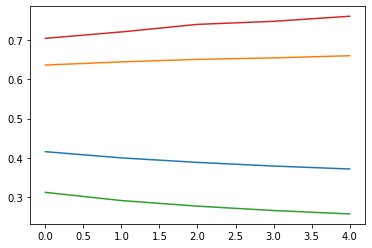

In [16]:
plt.plot(history.history["mean_absolute_error"])
plt.plot(history.history["val_mean_absolute_error"])

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

***Visualize loss***

In [17]:
# userPredictR = pd.DataFrame(model.predict([df_val.userId, df_val.movieId]))

    18/234376 [..............................] - ETA: 27:57  

2022-11-24 11:14:03.306880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


195928/234376 [========================>.....] - ETA: 2:02

***Model Prediction***